Inspired by the work of Gandino (2014) and Bottero & Oppio (2018), this script produces territorial maps to be used for spatial multicriteria analysis. 

I reproduced some from their work (distance from trails, hut density, distancce from natural parks). In addition I am creating several maps using data about water resources (rivers, lakes, derivations, water-wells etc.). 

Following their logic, each source map is normalized and combined with the other using WLC (Weighted Linear Combination), to obtain a comprehensive map about the elements considered. 

SCRIPT CRS: EPSG:32632

In [1]:
import geopandas as gpd
import numpy as np
import os
import rasterio
from rasterio.features import geometry_mask
from scipy.ndimage import distance_transform_edt
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from shapely.geometry import box
from scipy.ndimage import convolve

import functions as fun

# Load DEM
First I load the DEM (resolution 50m) since it is the base of all maps I will create.

In [2]:
DEM_PATH = '../data/terrain/tinitaly_dem500m.tif'
with rasterio.open(DEM_PATH) as src:
    dem = src.read(1)  # DEM data
    dem_transform = src.transform  # Affine transform for georeferencing
    dem_crs = src.crs 
    dem_profile = src.profile
    dem_shape = src.shape
    dem_bounds = src.bounds  # (left, bottom, right, top)
    dem_res = src.res[0]


# Functions

In [3]:
def compute_distance(gdf, norm=True, norm_threshold=500, dem_shape=dem_shape, dem_transform=dem_transform, dem_res=dem_res):
    ''' 
    Computes Euclidean distance for each cell of DEM from the nearest geometry in gdf (trails, rivers, etc.). 
    If norm=True, then norm_threshold is the value [meters] after which 
    the normalized distance function becomes zero.
    
    Returns: np.ndarray containing (normalized) distance. '''

    # Create a binary mask where cells with trails are False
    trail_mask = geometry_mask([geom for geom in gdf.geometry], 
                            out_shape=dem.shape,
                            transform=dem_transform, 
                            invert=True)

    # Compute the Euclidean distance transform on the binary mask
    distance_array = distance_transform_edt(~trail_mask) * dem_res
    standardized_distance = np.clip(1 - (distance_array / norm_threshold), 0, 1)

    return standardized_distance if norm else distance_array

    
def compute_density(points_gdf, radius=1, per_km2=True, dem_shape=dem_shape, dem_transform=dem_transform, dem_res=dem_res):
    ''' Compute density of points (water sources, huts, etc..) by rasterizing them.

    Parameters:
    - points_gdf: gdf containing points
    - radius: radius of kernel [number of cells]
    - per_mk2: if True, return density per km2, else return density per kernel area

    Returns:
    - density np.ndarray (non-zero)
    '''
    # Rasterize water (binary raster)
    points_raster = rasterize(
        [(geom, 1) for geom in points_gdf.geometry],
        out_shape=dem_shape,
        transform=dem_transform,
        fill=0,
        dtype='float'
    )
    print(f"Number of cells in raster: {np.sum(points_raster==0)}")
    print(f"Cells with data points: {np.sum(points_raster==1)}")

    # Create a circular kernel
    kernel = circular_kernel(radius)
    cell_area = dem_res**2  # area of one cell [m²]
    kernel_area = kernel.sum() * cell_area  # total area covered by the kernel [m²]

    # Apply convolution to compute number of springs per kernel area
    density_raster = convolve(points_raster, kernel, mode='constant', cval=0.0)
    if np.all(density_raster == 0):
        raise ValueError("Density is all zero, check for errors.")
        
    # Convert to springs per km²
    density_raster_km2 = density_raster * (1_000_000 / kernel_area)

    return density_raster_km2 if per_km2 else density_raster

def circular_kernel(radius):
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    return mask.astype(float) # sum of values in the area

# Individual maps (general)
## Distance from trails
Compute the eucledian distance from the nearest hiking trail for each cell in the DEM. Then, standardize it so that the value is 1 when the distance is zero and decreases until becoming zero for distances of more than 500m.

In [ ]:
# Load trails gdf
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf = trails_gdf.to_crs(dem_crs)

In [ ]:
trail_distance = compute_distance(trails_gdf, norm=False)
trail_distance_norm = compute_distance(trails_gdf, norm=True, norm_threshold=500)

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 8))

show(trail_distance, transform=dem_transform, cmap='YlGn', ax=axis[0])
plt.colorbar(axis[0].imshow(trail_distance, cmap='YlGn'), ax=axis[0], label='meters', shrink=0.3)
axis[0].set_title("Distance from Trails")

show(trail_distance_norm, transform=dem_transform, cmap='YlGn', ax=axis[1])
plt.colorbar(axis[1].imshow(trail_distance_norm, cmap='YlGn'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Distance from Trails")

plt.tight_layout()
plt.show()

In [ ]:
# Save raster map
#fun.save_raster_map(standardized_distance, dem_profile, filename='standardized_distance_trails')

## Hut's density
For each cell, count the number of huts within a radius (in number of cells). The results are standardized so that a value of 1 indicates the maximum number of huts observed for a cell and 0 is where there are no huts.

In [ ]:
# Load huts
huts_gdf = gpd.read_file('../data/huts/huts_points.geojson')
huts_gdf = huts_gdf.to_crs(dem_crs)

In [ ]:
huts_density_km2 = compute_density(huts_gdf)
# Optional: Normalize the density
huts_density_km2_norm = huts_density_km2 / huts_density_km2.max()

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(10, 10))

show(huts_density_km2, transform=dem_transform, cmap='binary_r', ax=axis[0])
plt.colorbar(axis[0].imshow(huts_density_km2, cmap='binary_r'), ax=axis[0], label='huts/km2', shrink=0.3)
axis[0].set_title("Hut Density")

show(huts_density_km2_norm, transform=dem_transform, cmap='binary_r', ax=axis[1])
plt.colorbar(axis[1].imshow(huts_density_km2_norm, cmap='binary_r'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Hut Density")

plt.tight_layout()
plt.show()

In [ ]:
# Save raster map
#fun.save_raster_map(huts_density_km2_norm, dem_profile, filename='norm_density_huts_km2')

## Distance from protected areas
For each cell, compute the distance from the closest natural park. Results are standardized so a value of 1 indicates distance of 0m and decreases until zero for a distance >= 1km. 

In [ ]:
# Load protected areas polygons
natural_parks = gpd.read_file('../data/others/nat_parks/z307_p_pup.shp')
natural_parks = natural_parks.to_crs(dem_crs)

# Compute
parks_distance = compute_distance(natural_parks, norm=False)
parks_distance_norm = compute_distance(natural_parks, norm=True, norm_threshold=500)

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(8, 8))

show(parks_distance, transform=dem_transform, cmap='YlGn', ax=axis[0])
plt.colorbar(axis[0].imshow(parks_distance, cmap='YlGn'), ax=axis[0], label='meters', shrink=0.3)
axis[0].set_title("Distance from Natural Parks")

show(parks_distance_norm, transform=dem_transform, cmap='YlGn', ax=axis[1])
plt.colorbar(axis[1].imshow(parks_distance_norm, cmap='YlGn'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Distance from Natural Parks")

plt.tight_layout()
plt.show()

In [ ]:
# Save raster map
#fun.save_raster_map(standardized_distance, dem_profile, filename='norm_distance_parks')

# Individual maps (water)
Note: all densities per km2 are computed with a radius of 1 cell (500m with DEM resolution being 500m) and normalized with min-max normalization.
## Superficial waters density
Source: carta risorse idriche PAT

In [8]:
def load_water_data(path, dem_crs=dem_crs, dem_bounds=dem_bounds): 
    ''' Loads gdf, sets CRS and clips it using DEM '''
    water_gdf = gpd.read_file(path)
    water_gdf = water_gdf.to_crs(dem_crs)
    dem_bbox = box(dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top)
    clipped_gdf = water_gdf[water_gdf.geometry.within(dem_bbox)]
    print(f"Number of data points: {len(clipped_gdf)}")
    return clipped_gdf

In [9]:
# Dictionary for storing rasters
water_rasters_norm = {}

In [10]:
# Load data
superficial_gdf = load_water_data('../data/water/carta_ris_idriche/pup_as/pup_as.shp')
# Compute density
density_raster_km2 = compute_density(superficial_gdf, per_km2=True)
# Optional: Normalize the density 
density_raster_km2_norm = density_raster_km2 / density_raster_km2.max()
water_rasters_norm['density_supwat'] = density_raster_km2_norm

Number of data points: 32
Number of cells in raster: 42566
Cells with data points: 27


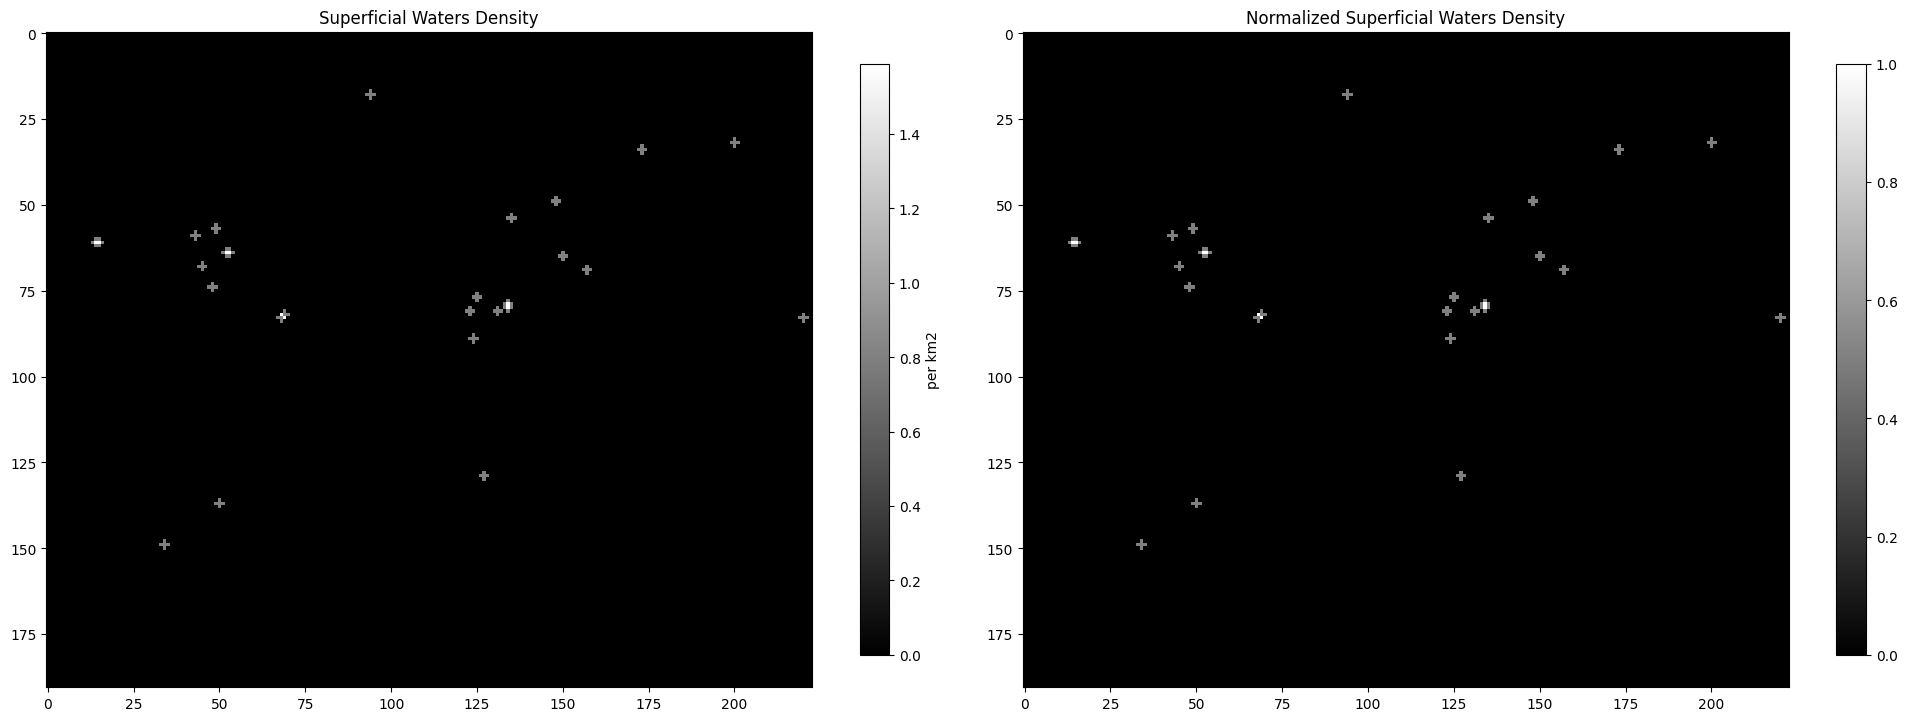

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(20, 20))

show(density_raster_km2, transform=dem_transform, cmap='binary_r', ax=axis[0])
plt.colorbar(axis[0].imshow(density_raster_km2, cmap='binary_r'), ax=axis[0], label='per km2', shrink=0.3)
axis[0].set_title("Superficial Waters Density")

show(density_raster_km2_norm, transform=dem_transform, cmap='binary_r', ax=axis[1])
plt.colorbar(axis[1].imshow(density_raster_km2_norm, cmap='binary_r'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Superficial Waters Density")

plt.tight_layout()
plt.show()

In [12]:
# Save raster map
#fun.save_raster_map(density_raster_km2_norm, dem_profile, filename='norm_density_superficialwaters_km2')

## Springs density
Source: carta risorse idriche PAT

In [13]:
# Load data
springs_gdf = load_water_data('../data/water/carta_ris_idriche/pup_so/pup_so.shp')
# Compute density
density_raster_km2 = compute_density(springs_gdf, per_km2=True)
# Optional: Normalize the density
density_raster_km2_norm = density_raster_km2 / density_raster_km2.max()
water_rasters_norm['density_springs'] = density_raster_km2_norm

Number of data points: 1858
Number of cells in raster: 41423
Cells with data points: 1170


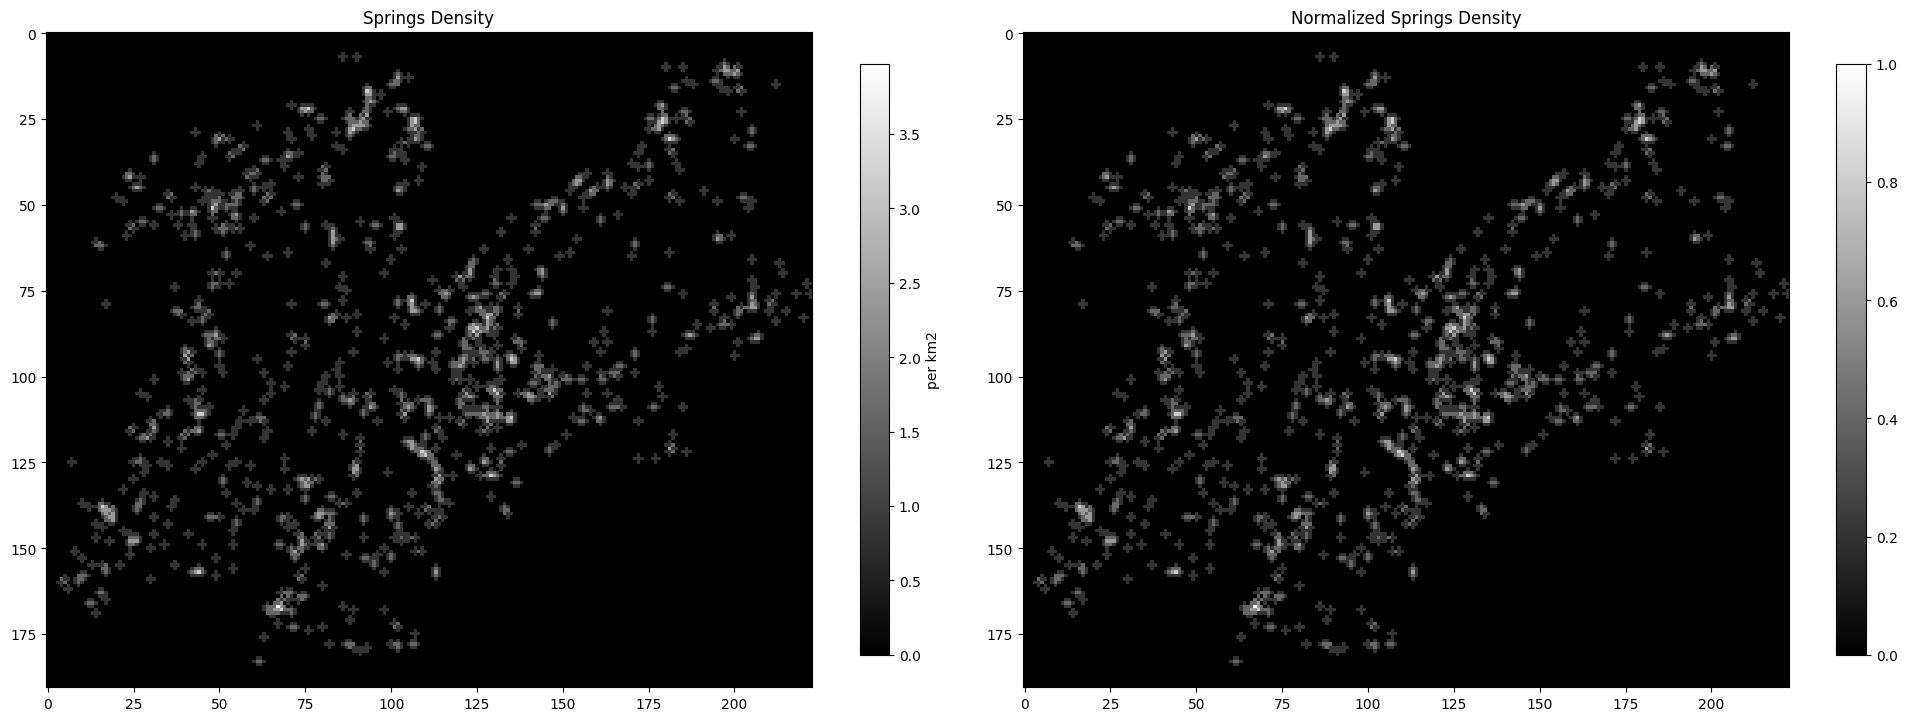

In [14]:
fig, axis = plt.subplots(1, 2, figsize=(20, 20))

show(density_raster_km2, transform=dem_transform, cmap='binary_r', ax=axis[0])
plt.colorbar(axis[0].imshow(density_raster_km2, cmap='binary_r'), ax=axis[0], label='per km2', shrink=0.3)
axis[0].set_title("Springs Density")

show(density_raster_km2_norm, transform=dem_transform, cmap='binary_r', ax=axis[1])
plt.colorbar(axis[1].imshow(density_raster_km2_norm, cmap='binary_r'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Springs Density")

plt.tight_layout()
plt.show()

In [15]:
# Save raster map
#fun.save_raster_map(density_raster_km2_norm, dem_profile, filename='norm_density_springs_km2')

In [16]:
# # Plot single density
# plt.figure(figsize=(10, 8))
# plt.imshow(density_raster_km2, cmap='binary_r', interpolation='nearest')
# plt.colorbar(label='Normalized Spring Presence')
# plt.title('Water Springs Density')
# plt.xlabel('Columns')
# plt.ylabel('Rows')
# plt.show()

## Water-wells density
Source: carta risorse idriche PAT

In [17]:
# Load data
wells_gdf = load_water_data('../data/water/carta_ris_idriche/pup_po/pup_po.shp')
# Compute density
density_raster_km2 = compute_density(wells_gdf, per_km2=True)
# Optional: Normalize the density 
density_raster_km2_norm = density_raster_km2 / density_raster_km2.max()
water_rasters_norm['density_watwells'] = density_raster_km2_norm

Number of data points: 153
Number of cells in raster: 42489
Cells with data points: 104


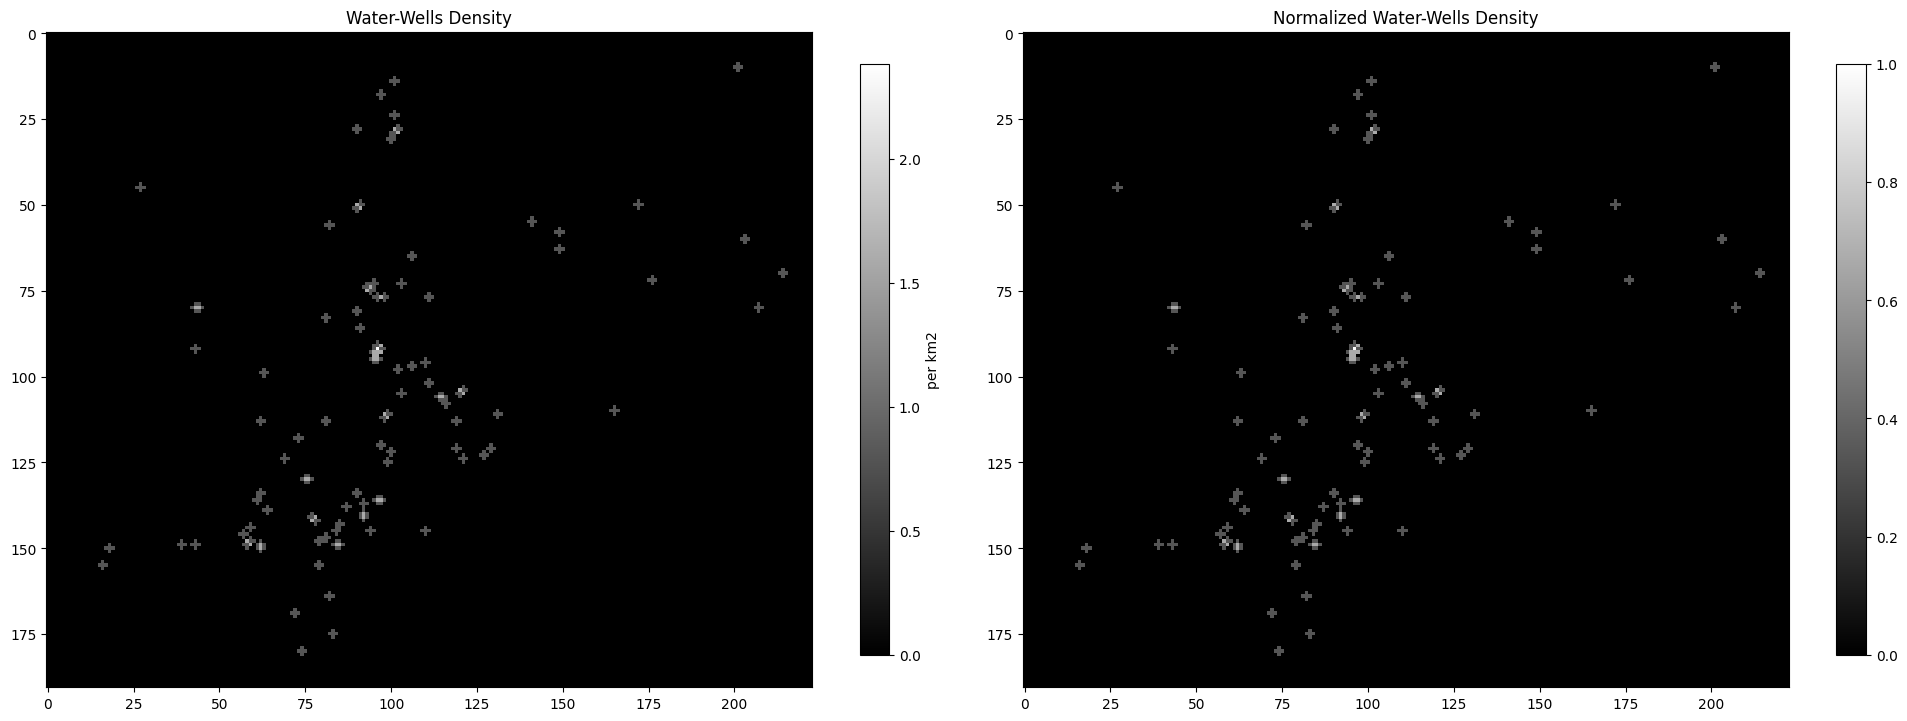

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(20, 20))

show(density_raster_km2, transform=dem_transform, cmap='binary_r', ax=axis[0])
plt.colorbar(axis[0].imshow(density_raster_km2, cmap='binary_r'), ax=axis[0], label='per km2', shrink=0.3)
axis[0].set_title("Water-Wells Density")

show(density_raster_km2_norm, transform=dem_transform, cmap='binary_r', ax=axis[1])
plt.colorbar(axis[1].imshow(density_raster_km2_norm, cmap='binary_r'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Water-Wells Density")

plt.tight_layout()
plt.show()

In [19]:
# Save raster map
#fun.save_raster_map(density_raster_km2_norm, dem_profile, filename='norm_density_waterwells_km2')

## Derivations density

In [20]:
derivaz_gdf = load_water_data('../data/water/derivazioni/pdi_derivazioni_v.shp')
derivaz_gdf.head(5)

Number of data points: 16875


,classid,objectid,numero_pra,stato_istr,stato_ist1,stato_oper,stato_ope1,attingimen,prelievo,restituzio,...,origine_p1,attend_pun,attend_pu1,desc_opera,idgdi,op_gedi_da,op_gedi_d1,datafine,dataagg,geometry
0,PDI001_1,1,C/13578,3,VALIDA-SCADUTA,01,ATTIVO,SI,SI,NO,...,Carta Tecnica,CT_CTP,CTP,1,None,2007-11-09 00:00:00,2009-11-08 00:00:00,None,2024-01-17 16:00:16,MULTIPOINT (658783.000 5135310.000)
1,PDI001_2,2,C/3161,3,VALIDA-SCADUTA,01,ATTIVO,SI,NO,SI,...,Domanda,DM_COR,Corografia,1,None,2005-10-27 00:00:00,2023-12-31 00:00:00,None,2024-01-17 16:00:16,MULTIPOINT (655281.000 5075917.000)
2,PDI001_3,3,C/1141,3,VALIDA-SCADUTA,01,ATTIVO,SI,NO,SI,...,Domanda,DM_COR,Corografia,1,None,2007-09-26 00:00:00,2019-12-31 00:00:00,None,2024-01-17 16:00:16,MULTIPOINT (637257.000 5111918.000)
3,PDI001_4,4,C/8793-2,2,VALIDA,01,ATTIVO,SI,SI,NO,...,Carta Tecnica,CT_CTP,CTP,1,None,1999-01-01 00:00:00,2026-12-31 00:00:00,None,2024-01-17 16:00:16,MULTIPOINT (665427.000 5120465.000)
4,PDI001_5,5,C/10158,2,VALIDA,01,ATTIVO,SI,SI,NO,...,Carta Tecnica,CT_CAT,Catastale,1,None,1999-01-01 00:00:00,2028-12-31 00:00:00,None,2024-01-17 16:00:16,MULTIPOINT (660923.000 5087318.000)


<Axes: >

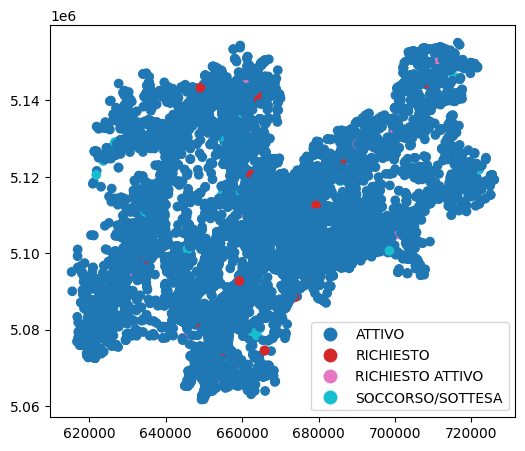

In [21]:
derivaz_gdf.plot(column='stato_ope1', legend=True, figsize=(6, 6))

In [22]:
# Compute density
density_raster_km2 = compute_density(derivaz_gdf, per_km2=True)
# Optional: Normalize the density 
density_raster_km2_norm = density_raster_km2 / density_raster_km2.max()
water_rasters_norm['density_derivaz'] = density_raster_km2_norm

Number of cells in raster: 36550
Cells with data points: 6043


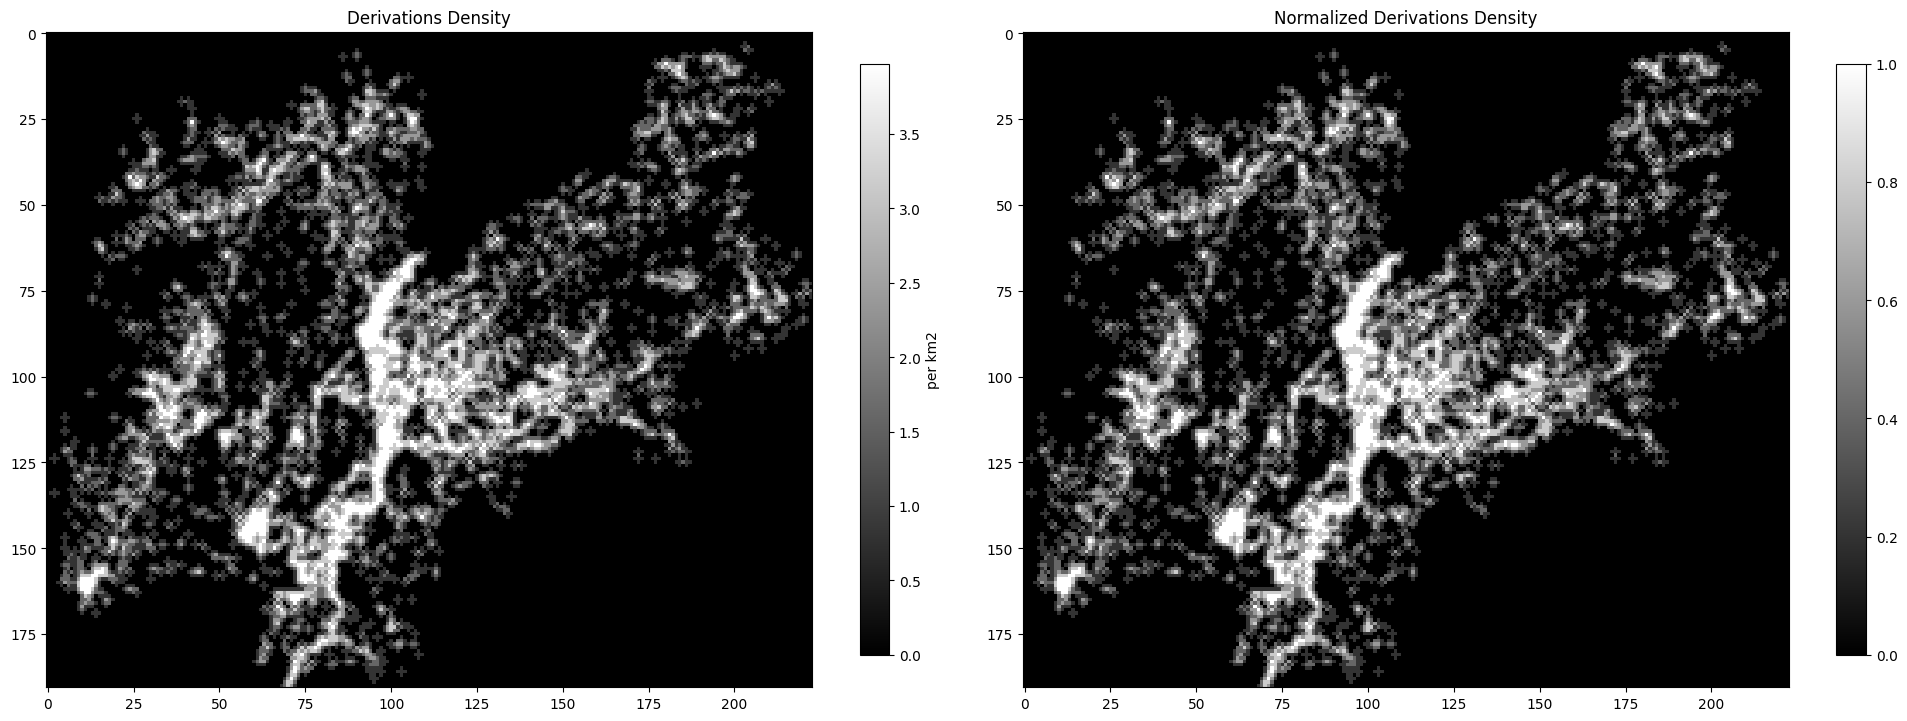

In [23]:
fig, axis = plt.subplots(1, 2, figsize=(20, 20))

show(density_raster_km2, transform=dem_transform, cmap='binary_r', ax=axis[0])
plt.colorbar(axis[0].imshow(density_raster_km2, cmap='binary_r'), ax=axis[0], label='per km2', shrink=0.3)
axis[0].set_title("Derivations Density")

show(density_raster_km2_norm, transform=dem_transform, cmap='binary_r', ax=axis[1])
plt.colorbar(axis[1].imshow(density_raster_km2_norm, cmap='binary_r'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Derivations Density")

plt.tight_layout()
plt.show()

## Distance from rivers
Source: corpi idrici fluviali 2022 (PAT)

In [24]:
cif_gdf = load_water_data('../data/water/corpi_fluv/cif_pta2022_v.shp')
cif_distance = compute_distance(cif_gdf, norm=False)
cif_distance_norm = compute_distance(cif_gdf, norm=True, norm_threshold=500)
water_rasters_norm['distance_rivers'] = cif_distance_norm

Number of data points: 371


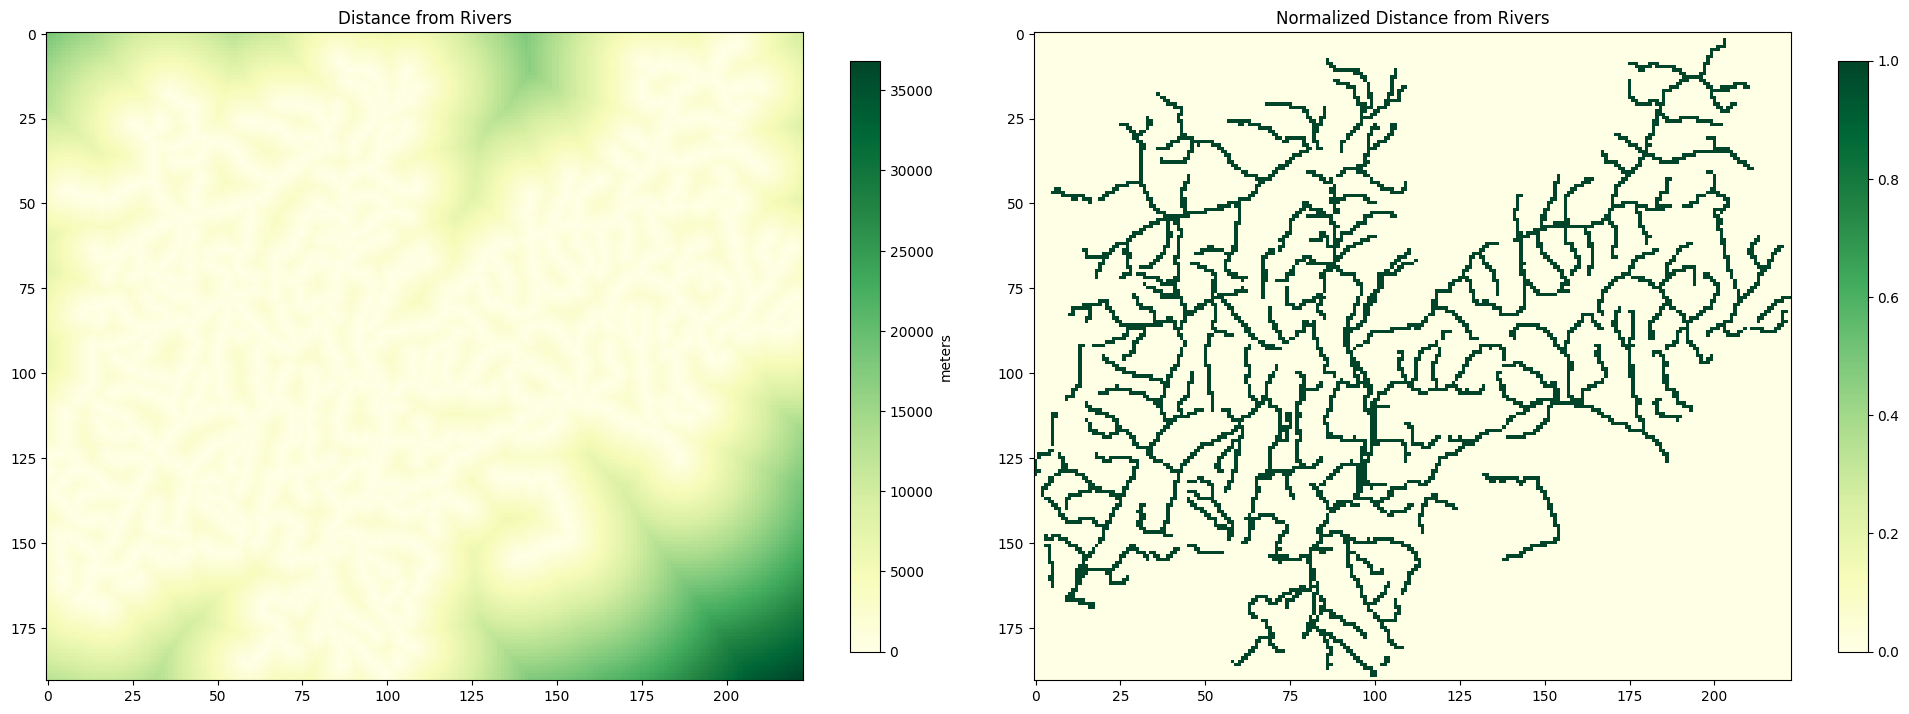

In [25]:
fig, axis = plt.subplots(1, 2, figsize=(20, 20))

show(cif_distance, transform=dem_transform, cmap='YlGn', ax=axis[0])
plt.colorbar(axis[0].imshow(cif_distance, cmap='YlGn'), ax=axis[0], label='meters', shrink=0.3)
axis[0].set_title("Distance from Rivers")

show(cif_distance_norm, transform=dem_transform, cmap='YlGn', ax=axis[1])
plt.colorbar(axis[1].imshow(cif_distance_norm, cmap='YlGn'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Distance from Rivers")

plt.tight_layout()
plt.show()

## Distance from lakes
Source: corpi idrici lacustri 2022 (PAT)

In [26]:
# Do not clip using DEM else Garda is cut out
cil_gdf = gpd.read_file('../data/water/corpi_laghi/cil_pta2022_v.shp')
cil_gdf = cil_gdf.to_crs(dem_crs)
cil_distance = compute_distance(cil_gdf, norm=False)
cil_distance_norm = compute_distance(cil_gdf, norm=True, norm_threshold=500)
water_rasters_norm['distance_lakes'] = cil_distance_norm

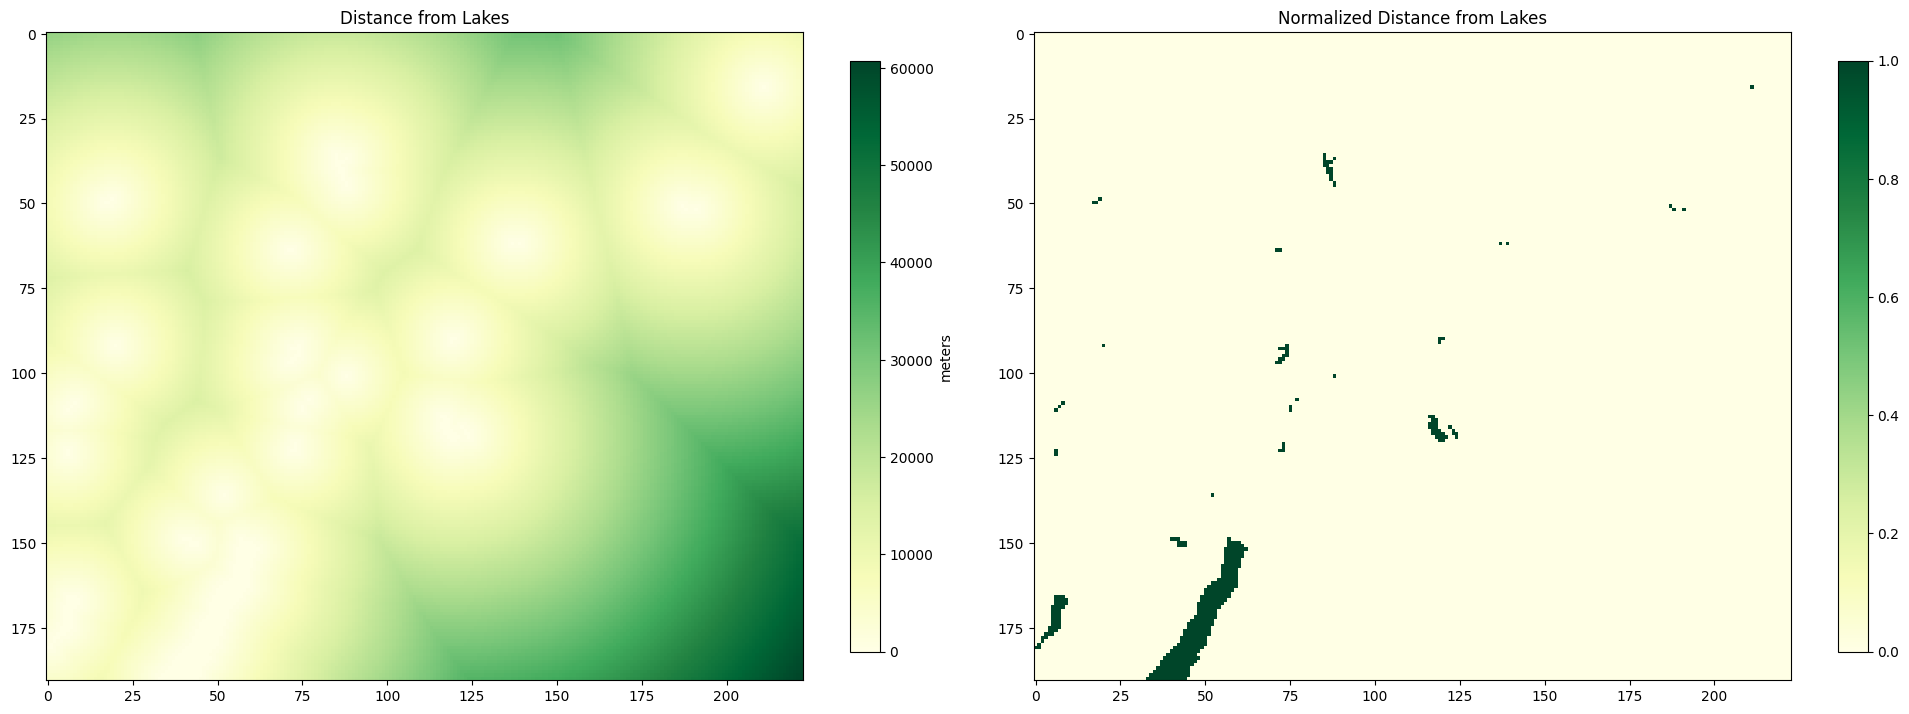

In [27]:
fig, axis = plt.subplots(1, 2, figsize=(20, 20))

show(cil_distance, transform=dem_transform, cmap='YlGn', ax=axis[0])
plt.colorbar(axis[0].imshow(cil_distance, cmap='YlGn'), ax=axis[0], label='meters', shrink=0.3)
axis[0].set_title("Distance from Lakes")

show(cil_distance_norm, transform=dem_transform, cmap='YlGn', ax=axis[1])
plt.colorbar(axis[1].imshow(cil_distance_norm, cmap='YlGn'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Distance from Lakes")

plt.tight_layout()
plt.show()

## Distance from glaciers
Source: geocatalogo PAT - Ghiacciai 2015 (most recent)

In [28]:
ghi_gdf = load_water_data('../data/water/glaciers2015/Ghi_2015.shp')
ghi_distance = compute_distance(ghi_gdf, norm=False)
ghi_distance_norm = compute_distance(ghi_gdf, norm=True, norm_threshold=500)
water_rasters_norm['distance_glaciers'] = ghi_distance_norm

Number of data points: 149


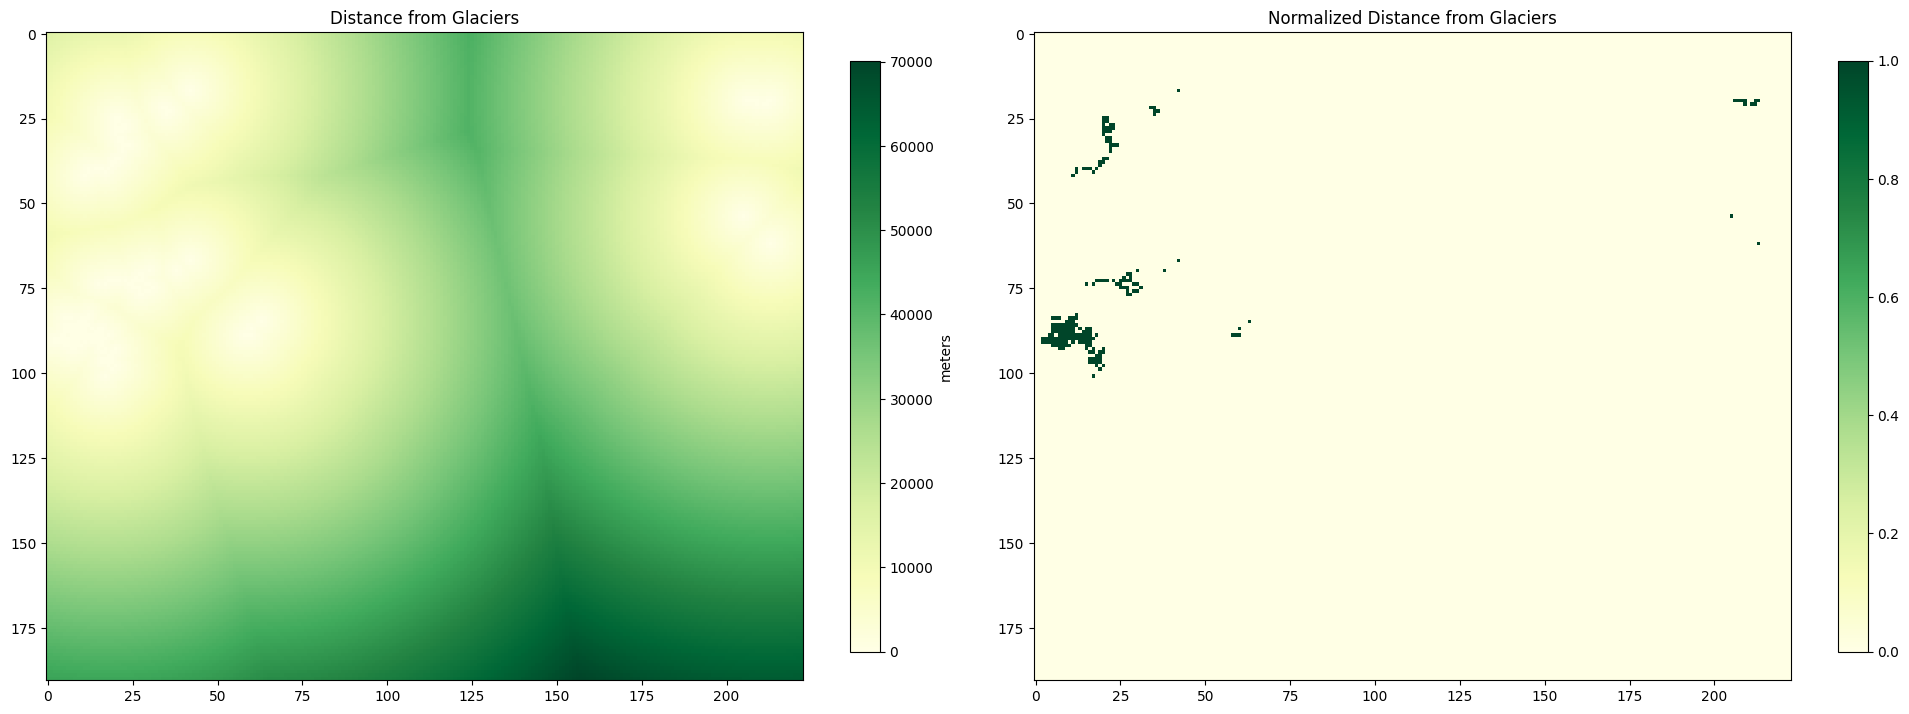

In [29]:
fig, axis = plt.subplots(1, 2, figsize=(20, 20))

show(ghi_distance, transform=dem_transform, cmap='YlGn', ax=axis[0])
plt.colorbar(axis[0].imshow(ghi_distance, cmap='YlGn'), ax=axis[0], label='meters', shrink=0.3)
axis[0].set_title("Distance from Glaciers")

show(ghi_distance_norm, transform=dem_transform, cmap='YlGn', ax=axis[1])
plt.colorbar(axis[1].imshow(ghi_distance_norm, cmap='YlGn'), ax=axis[1], label='', shrink=0.3)
axis[1].set_title("Normalized Distance from Glaciers")

plt.tight_layout()
plt.show()

## MODIS Snow Maps
Load Snow Cover Duration and Snow Cover Frequency maps created in modis_maps.ipynb for 3 time periods between 2021-2024. These maps add information about snow as a water resource: they can highlight areas where snow is more persistent over the course of the year, useful for water catchment and identifying areas where fusion water is scarce.

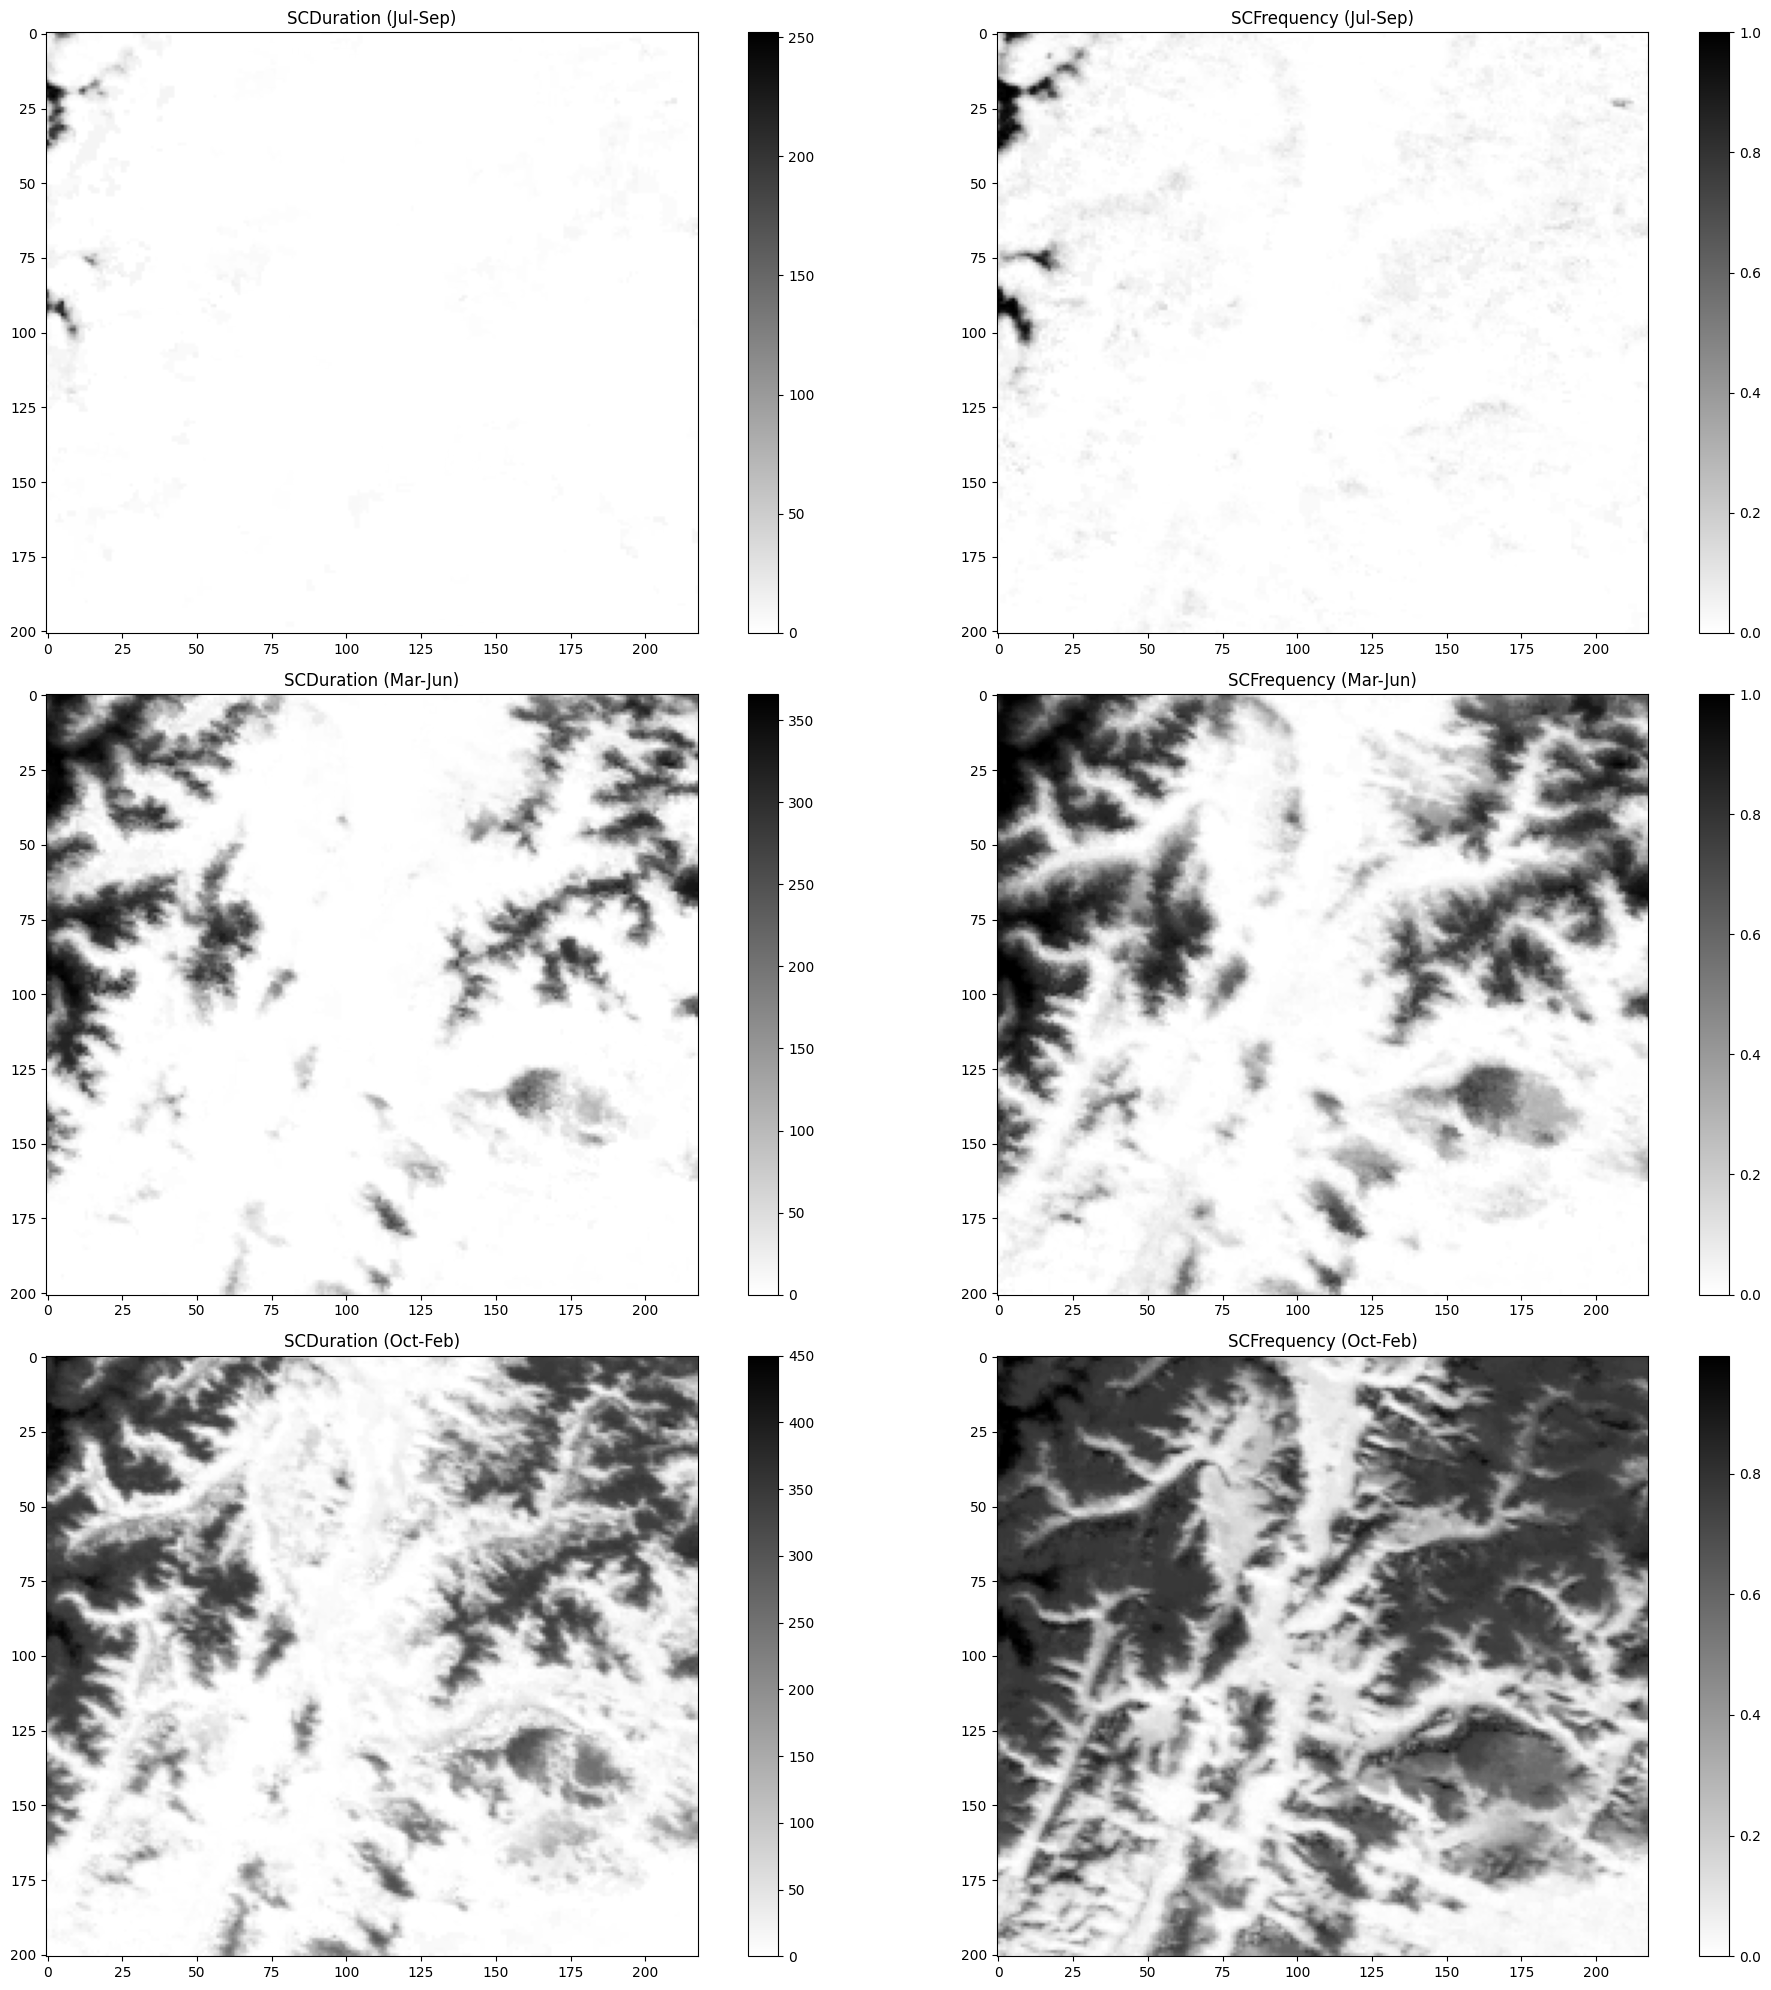

In [30]:
# Plot all maps
results_SCD = ['../data/maps/SCD_late_summer.tif',
'../data/maps/SCD_melting_season.tif',
'../data/maps/SCD_snow_season.tif']

results_SCF = ['../data/maps/SCF_late_summer.tif',
'../data/maps/SCF_melting_season.tif',
'../data/maps/SCF_snow_season.tif']

period_map = {
    'snow_season': 'Oct-Feb',
    'melting_season': 'Mar-Jun',
    'late_summer': 'Jul-Sep'}
    
fig, ax = plt.subplots(3, 2, figsize=(20,20))
i = 0
for file_scd, file_scf in zip(results_SCD, results_SCF):
    
    with rasterio.open(file_scd) as src:
        scd = src.read(1)
    
    period_name_scd = '_'.join(os.path.basename(file_scd).split('.')[0].split('_')[-2:])

    with rasterio.open(file_scf) as src:
        scf = src.read(1)

    period_name_scf = '_'.join(os.path.basename(file_scf).split('.')[0].split('_')[-2:])
    assert period_name_scf == period_name_scd

    ax[i, 0].imshow(scd, cmap='binary')
    plt.colorbar(ax[i, 0].imshow(scd, cmap='binary'), ax=ax[i, 0])
    ax[i, 0].set_title(f"SCDuration ({period_map[period_name_scd]})")

    ax[i, 1].imshow(scf, cmap='binary')
    plt.colorbar(ax[i, 1].imshow(scf, cmap='binary'), ax=ax[i, 1])
    ax[i, 1].set_title(f"SCFrequency ({period_map[period_name_scf]})")
    
    i += 1

plt.tight_layout()
plt.show()


In [31]:
from rasterio.warp import reproject, Resampling
from rasterio.io import MemoryFile

def reproject_and_clip_raster2(input_raster_path, dem_path):
    with rasterio.open(input_raster_path) as src:
        input_crs = src.crs
        input_transform = src.transform
        input_array = src.read(1)

    with rasterio.open(dem_path) as dem_src:
        dem_crs = dem_src.crs
        dem_transform = dem_src.transform
        dem_shape = dem_src.shape

    # Create an empty array to hold the reprojected data
    reprojected_array = np.empty(dem_shape, dtype=np.float32)

    # Reproject the data to match the DEM's CRS and dimensions
    reproject(
        source=input_array,
        destination=reprojected_array,
        src_transform=input_transform,
        src_crs=input_crs,
        dst_transform=dem_transform,
        dst_crs=dem_crs,
        resampling=Resampling.nearest,
    )

    # Mask the reprojected data to match the DEM bounds
    reprojected_clipped_array = reprojected_array.copy()

    return reprojected_clipped_array, dem_transform


In [32]:
# Normalize maps (min-max) & save in dictionary
MODIS_DIR = '../data/maps'
modis_maps = [file for file in os.listdir(MODIS_DIR) if 'SC' in file[:2]]
for filename in modis_maps:
    print(f"Processing file: {filename}...")
    filepath = os.path.join(MODIS_DIR, filename)
    # open and clip 
    clipped_data,_ =  reproject_and_clip_raster2(filepath, DEM_PATH)

    # min-max norm
    norm_data = clipped_data / clipped_data.max()

    # save in dictionary
    mapname = filename.split('.')[0]
    water_rasters_norm[mapname] = norm_data

Processing file: SCF_snow_season.tif...
Processing file: SCD_late_summer.tif...
Processing file: SCD_melting_season.tif...
Processing file: SCD_snow_season.tif...
Processing file: SCF_late_summer.tif...
Processing file: SCF_melting_season.tif...


# Water Availability Map

In [ ]:
rasters = [data_array for layer, data_array in water_rasters_norm.items()]

raster_shapes = [r.shape for r in rasters]
if len(set(raster_shapes)) > 1:
    raise ValueError("Rasters do not have the same shape. Ensure alignment.")

for idx, raster in enumerate(rasters):
    if (raster.min() < 0) or (raster.max() > 1):
        err_raster = water_rasters_norm[list(water_rasters_norm.keys())[idx]]
        raise ValueError(f"Raster {err_raster} is not normalized. Ensure normalization.")

# Compute the combined raster (equal weights)
weights = 1 / len(rasters)
combined_raster = sum(weights * raster for raster in rasters)

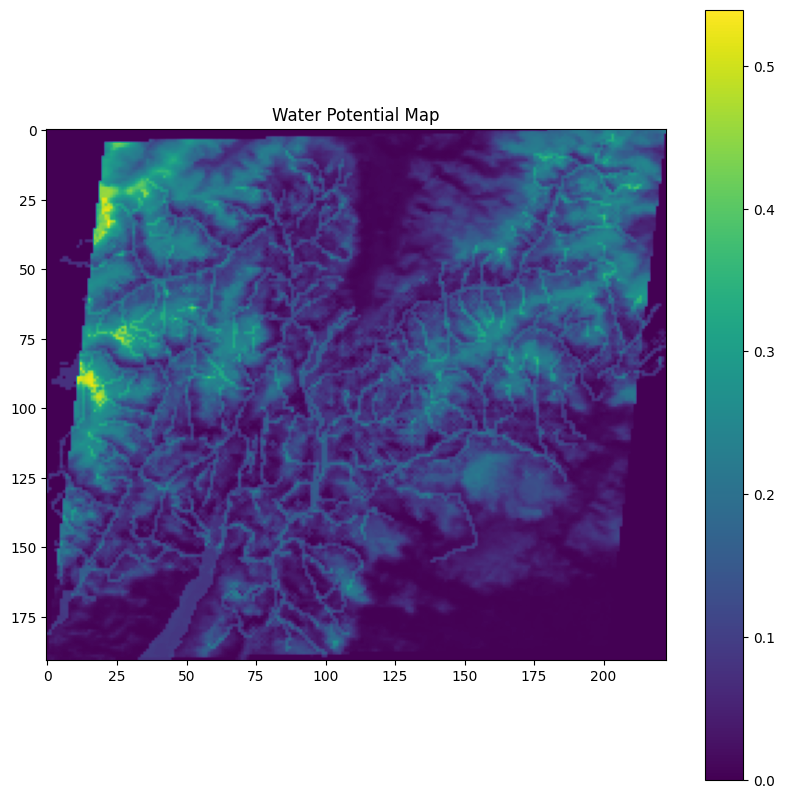

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(combined_raster, cmap='viridis')  # to set colorbar range: vmin=0, vmax=1 
cbar = plt.colorbar(cax)
plt.title("Water Potential Map")
plt.show()

In [36]:
# TODO: save combined raster map
fun.save_raster_map(combined_raster, dem_profile, filename='water_potential_map', destination_dir = '../data/maps/')